## Project 6 - Recommendation System
Amazon Reviews data [source](http://jmcauley.ucsd.edu/data/amazon/). The repository has several datasets. For this case study, we are using the Electronics dataset.

**Domain**: E-Commerce

**Context**: Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

**Attribute Information**
* `UserID`: Every user identified with a unique id.
* `ProductID`: Every product identified with a unique id.
* `Rating`: Rating of the corresponding product by the corresponding user.
* `timestamp`: Time of the rating.

**Learning Outcomes**
* Exploratory Data Analysis
* Creating a recommendation system using real data
* Collaborative filtering

**Objective**: Build a recommendation system to recommend products to customers based on their previous ratings for other products.

In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Setting the current working directory
import os; os.chdir('drive/My Drive/Great Learning/Recommendation System')

In [3]:
!ls '/content/drive/My Drive/Great Learning/Recommendation System'

'06_Recommendation System_Pratik.ipynb'   ratings_Electronics.csv


<a id='import'></a>
### Import Packages

In [4]:
!pip install scikit-surprise

In [0]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style; style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
import gc
%matplotlib inline

# Surprise package for making recommendation
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise.model_selection import GridSearchCV, cross_validate, KFold
from surprise import accuracy, Reader, Dataset, dump

# For Sklearn NearestNeighbor based recommendation
from sklearn.metrics import pairwise_distances, mean_squared_error
from scipy.spatial.distance import correlation, cosine
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import sklearn.metrics as metrics
from math import sqrt

# Display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 20
pd.options.display.float_format = "{:.2f}".format

random_state = 2019
np.random.seed(random_state)

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

<a id='read'></a>
### Read and explore the dataset

In [6]:
# Reading the data as dataframe and print the first five rows
ratings = pd.read_csv('ratings_Electronics.csv', header = None)
ratings.columns = ['UserID', 'ProductID', 'Rating', 'Timestamp']
ratings.head()

,UserID,ProductID,Rating,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.00,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.00,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.00,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.00,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.00,1334707200


In [7]:
# Get info of the dataframe columns
print('Get info of the dataframe columns'); print('--'*40)
ratings.info()

Get info of the dataframe columns
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
UserID       object
ProductID    object
Rating       float64
Timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [8]:
# Check if there any null values in the dataframe
print('There are no null values in the dataset'); print('--'*40)
ratings.isnull().sum()

There are no null values in the dataset
--------------------------------------------------------------------------------


UserID       0
ProductID    0
Rating       0
Timestamp    0
dtype: int64

In [9]:
# Check if there are any duplicate rows
print('Dataset has no duplicate rows'); print('--'*40)
ratings[ratings.duplicated(keep = 'first')]

Dataset has no duplicate rows
--------------------------------------------------------------------------------


,UserID,ProductID,Rating,Timestamp


In [10]:
# Checking the uniques in `Rating` column
print('Checking the uniques in Rating column'); print('--'*40)
sorted(list(ratings['Rating'].unique()))

Checking the uniques in Rating column
--------------------------------------------------------------------------------


[1.0, 2.0, 3.0, 4.0, 5.0]

<a id='o1'></a>
#### Observation 1 - Dataset shape
Dataset has more than 7.8 million reviews and with information regarding user id, product id, rating and timestamp. There are no missing values and duplicates in the dataset. Ratings are on the scale of 1-5.

<a id='o2'></a>
#### Observation 2 - Information on the type of variable

* `userID`: Every user identified with a unique id (Categorical, Nominal).
* `productID`: Every product identified with a unique id (Categorical, Nominal).
* `Rating`: Rating of the corresponding product by the corresponding user (Numerical, Discrete).
* `Timestamp`: Time of the rating (Timestamp).

In [11]:
### Five point summary of numerical attributes and check unique values in 'object' columns
print('Five point summary of the dataframe'); print('--'*40)

ratings.describe(include = 'all')

Five point summary of the dataframe
--------------------------------------------------------------------------------


,UserID,ProductID,Rating,Timestamp
count,7824482,7824482,7824482.00,7824482.00
unique,4201696,476002,nan,nan
top,A5JLAU2ARJ0BO,B0074BW614,nan,nan
freq,520,18244,nan,nan
mean,NaN,NaN,4.01,1338178197.27
std,NaN,NaN,1.38,69004257.79
min,NaN,NaN,1.00,912729600.00
25%,NaN,NaN,3.00,1315353600.00
50%,NaN,NaN,5.00,1361059200.00
75%,NaN,NaN,5.00,1386115200.00


In [12]:
display(sorted(list(ratings['ProductID'].unique()))[0:5], sorted(list(ratings['ProductID'].unique()))[-5:])

['0132793040', '0321732944', '0439886341', '0511189877', '0528881469']

['BT008G3W52', 'BT008SXQ4C', 'BT008T2BGK', 'BT008UKTMW', 'BT008V9J9U']

<a id='o3'></a>
#### Observation 3 - Descriptive statistics
* **`UserID`**: Categorical column with alphanumeric user id. Number of users in the dataset: 4201696.
* **`ProductID`**: Categorical column with some of the product ids being numerical entries and some being alphanumerics. Numbers of rated products: 476002.
* **`Rating`**: Users have rated the products on the scale of 1 to 5.
* **`Timestamp`**: Can be useful if we convert the numerical timestamp to datetime.

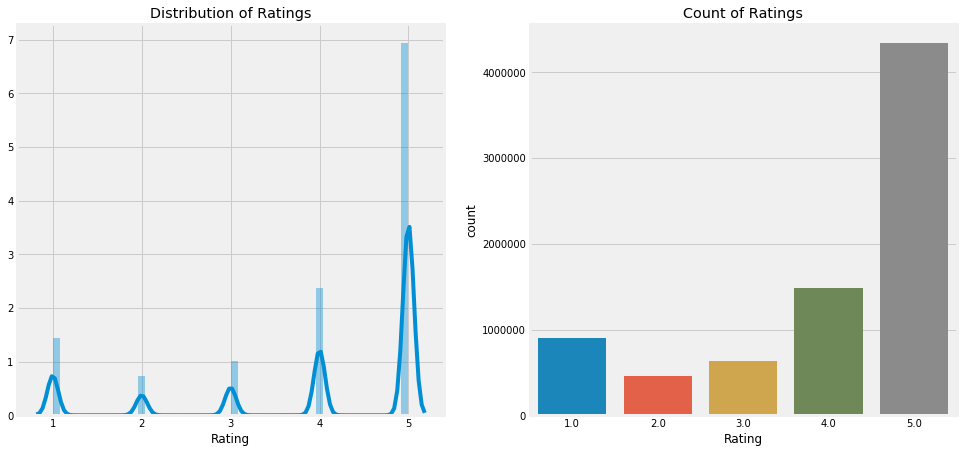

In [13]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(121)
g = sns.distplot(ratings['Rating'], ax = ax).set_title('Distribution of Ratings')
ax = fig.add_subplot(122)
g = sns.countplot(ratings['Rating']).set_title('Count of Ratings')

In [0]:
ratings['Timestamp'] = pd.to_datetime(ratings['Timestamp'], unit = 's')
ratings['Year'] = ratings['Timestamp'].dt.year

Trend of ratings over the years
--------------------------------------------------------------------------------


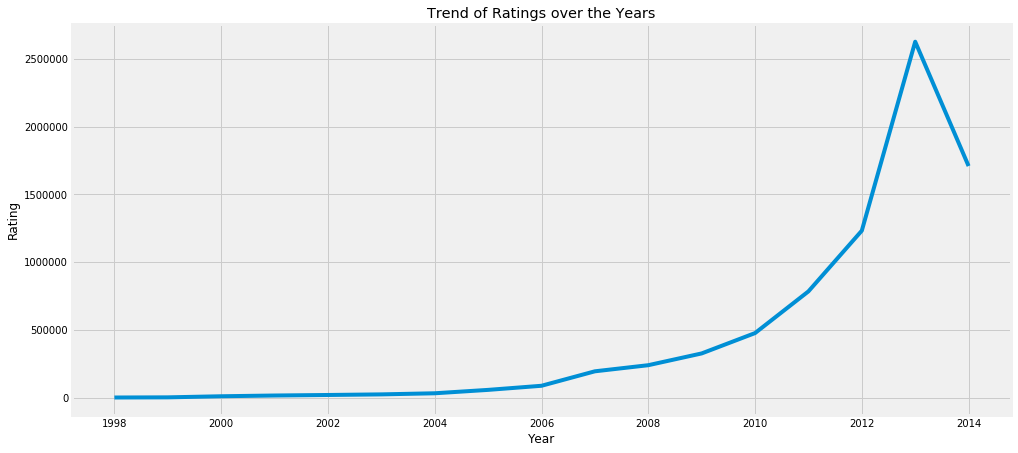

In [15]:
print('Trend of ratings over the years'); print('--'*40)
ratings_over_years = ratings.groupby(by = 'Year', as_index = False)['Rating'].count()

fig = plt.figure(figsize = (15, 7.2))
g = sns.lineplot(x = 'Year', y = 'Rating', data = ratings_over_years).set_title('Trend of Ratings over the Years')

del g, ratings_over_years

Yearwise Counts for Ratings. Trend is similar across rating category.
Most of the users have rated 5 on products and highest number of ratings came in 2013.
--------------------------------------------------------------------------------


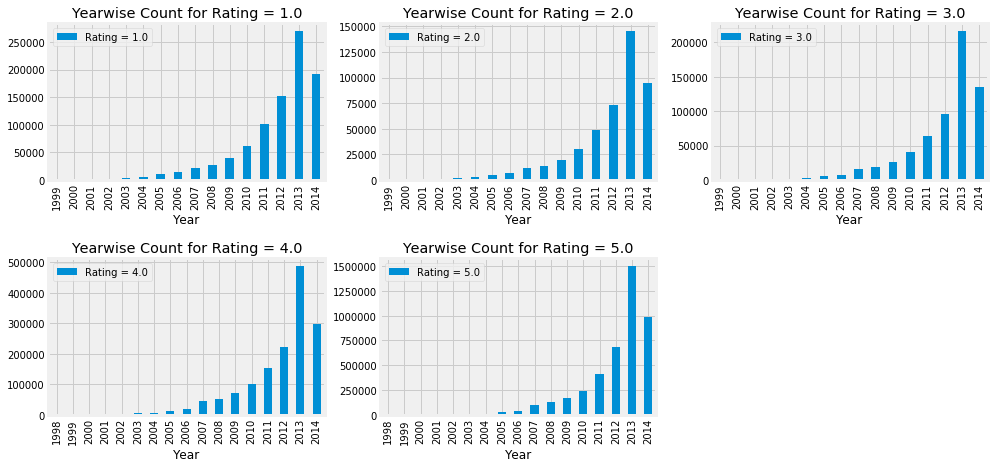

In [16]:
#http://jonathansoma.com/lede/data-studio/classes/small-multiples/long-explanation-of-using-plt-subplots-to-create-small-multiples/
print('Yearwise Counts for Ratings. Trend is similar across rating category.'); 
print('Most of the users have rated 5 on products and highest number of ratings came in 2013.'); print('--'*40)

year_wise_ratings = pd.DataFrame(ratings.groupby(['Rating', 'Year'], as_index = False)['UserID'].count())
year_wise_ratings.rename(columns = {'UserID': 'Counts'}, inplace = True)
ratings_ = sorted(year_wise_ratings['Rating'].unique())

fig, axes = plt.subplots(nrows = 2, ncols = 3, squeeze = False, figsize = (15, 7.2))
plt.subplots_adjust(hspace = 0.5)
axes_list = [item for sublist in axes for item in sublist] 

for rating in ratings_:
    ax = axes_list.pop(0)
    g = year_wise_ratings[year_wise_ratings['Rating'] == rating].plot(kind = 'bar', x ='Year', y = 'Counts', label = f'Rating = {rating}', 
                                                                  ax = ax, legend = True)
    ax.set_title(f'Yearwise Count for Rating = {rating}')

for ax in axes_list:
    ax.remove()

del ax, axes, axes_list, fig, rating, ratings_, year_wise_ratings

In [17]:
print('Adding a column with count of rating per user'); print('--'*40)
userid = ratings['UserID'].value_counts()
userid = pd.DataFrame(userid).reset_index()
userid.columns = ['UserID', 'UserIDCounts']

ratings_df = ratings.merge(userid, how = 'left', on = ['UserID'])
display(ratings_df.shape, ratings_df.head())

del userid

Adding a column with count of rating per user
--------------------------------------------------------------------------------


(7824482, 6)

,UserID,ProductID,Rating,Timestamp,Year,UserIDCounts
0,AKM1MP6P0OYPR,0132793040,5.00,2013-04-13,2013,2
1,A2CX7LUOHB2NDG,0321732944,5.00,2012-07-01,2012,4
2,A2NWSAGRHCP8N5,0439886341,1.00,2013-04-29,2013,1
3,A2WNBOD3WNDNKT,0439886341,3.00,2013-07-22,2013,1
4,A1GI0U4ZRJA8WN,0439886341,1.00,2012-04-18,2012,1


In [18]:
# Number of unique user id and product id in the data
print('Number of unique USERS and PRODUCT IDs in the raw ratings dataframe'); print('--'*40)
print('Number of unique USERS in raw ratings dataframe = ', ratings_df['UserID'].nunique())
print('Number of unique PRODUCTS in raw ratings dataframe = ', ratings_df['ProductID'].nunique())

Number of unique USERS and PRODUCT IDs in the raw ratings dataframe
--------------------------------------------------------------------------------
Number of unique USERS in raw ratings dataframe =  4201696
Number of unique PRODUCTS in raw ratings dataframe =  476002


Distribution of Ratings per User is sparser
Maximum number of rating per user being 520 and minimum being 1
--------------------------------------------------------------------------------


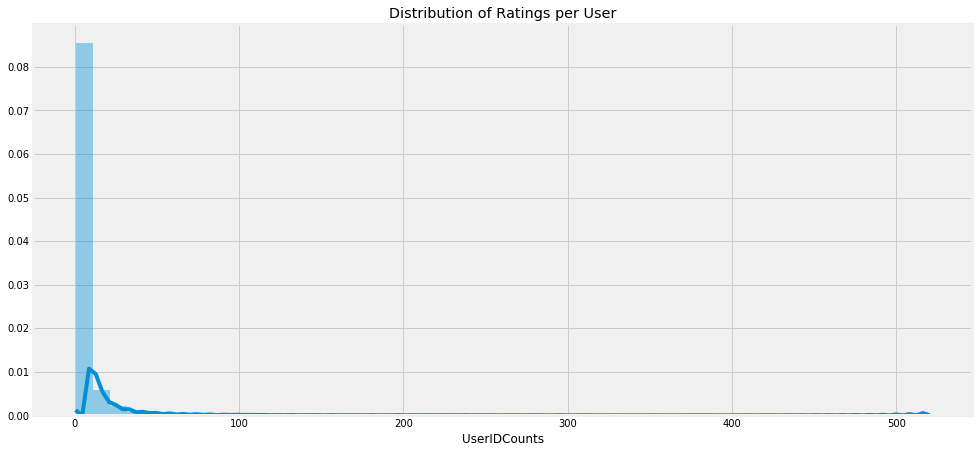

In [19]:
print('Distribution of Ratings per User is sparser')
print('Maximum number of rating per user being {maxm} and minimum being {minm}'.format(maxm = ratings_df['UserIDCounts'].max(), 
                                                                                       minm = ratings_df['UserIDCounts'].min()))
print('--'*40)
fig = plt.figure(figsize = (15, 7.2))
g = sns.distplot(ratings_df['UserIDCounts'], bins = 50).set_title('Distribution of Ratings per User')

del fig, g

In [20]:
print('Taking a subset of dataset to make it less sparse/denser')
print('Keeping users those who have given more than 49 number of ratings'); print('--'*40)

ratings_df = ratings_df[ratings_df['UserIDCounts'] >= 50]
print('Number of rows after filtering: {}'.format(ratings_df.shape[0]))

Taking a subset of dataset to make it less sparse/denser
Keeping users those who have given more than 49 number of ratings
--------------------------------------------------------------------------------
Number of rows after filtering: 125871


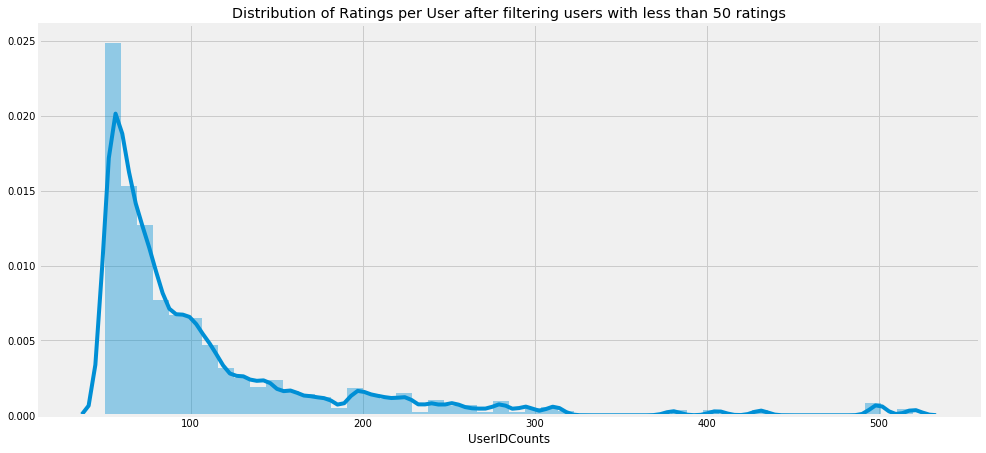

In [21]:
fig = plt.figure(figsize = (15, 7.2))
g = sns.distplot(ratings_df['UserIDCounts'], bins = 50).set_title('Distribution of Ratings per User after filtering users with less than 50 ratings')

del fig, g

In [22]:
print('Number of product ids after filtering based on ratings given by users: {}'.format(ratings_df['ProductID'].nunique()))

Number of product ids after filtering based on ratings given by users: 48190


In [23]:
print('Selecting only UserID, ProductID and \'Rating\' column'); print('--'*40)
ratings = ratings_df[['UserID', 'ProductID', 'Rating']]

Selecting only UserID, ProductID and 'Rating' column
--------------------------------------------------------------------------------


In [24]:
# Number of unique user id and product id in the data
print('Number of unique USERS and PRODUCT IDs in the filtered ratings dataframe'); print('--'*40)
print('Number of unique USERS in filtered ratings dataframe = ', ratings['UserID'].nunique())
print('Number of unique PRODUCTS in filtered ratings dataframe = ', ratings['ProductID'].nunique())

Number of unique USERS and PRODUCT IDs in the filtered ratings dataframe
--------------------------------------------------------------------------------
Number of unique USERS in filtered ratings dataframe =  1540
Number of unique PRODUCTS in filtered ratings dataframe =  48190


In [25]:
# Top and bottom 10 users based on # of ratings given
print('Top 10 users based on # of ratings given'); print('--'*40)
most_rated = ratings.groupby('UserID').size().sort_values(ascending = False)[:10]
display(most_rated)

print('\nBottom 10 users based on # of ratings given'); print('--'*40)
least_rated = ratings.groupby('UserID').size().sort_values(ascending = True)[:10]
display(least_rated)

del most_rated, least_rated

Top 10 users based on # of ratings given
--------------------------------------------------------------------------------


UserID
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64


Bottom 10 users based on # of ratings given
--------------------------------------------------------------------------------


UserID
A2RS66Y79Q8X0W    50
A2Y4H3PXB07WQI    50
A3VZH0PWLQ9BB1    50
A19N3S7CBSU6O7    50
A1IU4UAV9QIJAI    50
A319Y83RT0MRVR    50
A27H61OHW44XA7    50
A2JRDFIGWTX50J    50
A2RGA7UGAN3UL7    50
ACH055GTTIGC9     50
dtype: int64

<a id='recommendations'></a>
### Recommenders
We will explore following methods of making recommendations:
* Popularity based recommendations
* Collaborative filtering (User-based and Item-based recommendations)

In [26]:
train_data, test_data = train_test_split(ratings, test_size = 0.30, random_state = random_state)
display(train_data.shape, test_data.shape)

(88109, 3)

(37762, 3)

In [27]:
print('Number of unique users in training dataframe {}'.format(train_data['UserID'].nunique()))
print('Number of unique users in test dataframe: {}'.format(test_data['UserID'].nunique()))
print('Number of products that aren\'t present in test dataframe: '.format(len(list(set(list(train_data['ProductID'].unique())) - set(list(test_data['ProductID'].unique()))))))

Number of unique users in training dataframe 1540
Number of unique users in test dataframe: 1540
Number of products that aren't present in test dataframe: 


In [28]:
print('Number of unique products in training dataframe {}'.format(train_data['ProductID'].nunique()))
print('Number of unique products in test dataframe: {}'.format(test_data['ProductID'].nunique()))
print('Number of products that aren\'t present in test dataframe: {}'.format(len(list(set(list(train_data['ProductID'].unique())) - set(list(test_data['ProductID'].unique()))))))

Number of unique products in training dataframe 38184
Number of unique products in test dataframe: 21323
Number of products that aren't present in test dataframe: 26867


<a id='popularity'></a>
#### **Popularity based recommendations**
* Create a class to make recommendation using popularity based method.
* Get top 5 recommendations for couple of users, recommendations are based on the Rating means for the Product IDs. However will later explore other methods as well.
* Comment on the findings.

In [0]:
#Class for Popularity based Recommender System
class popularity_recommender():   
    def __init__(self):
      self.trainSet = None
      self.userId = None
      self.productId = None
      self.popularityRecommendations = None
      self.topN = None
    def create(self, trainSet, userId, productId, topN):
      self.trainSet = trainSet
      self.userId = userId
      self.productId = productId
      self.topN = topN

      byRating = self.trainSet.groupby('ProductID', sort = False, as_index = False)['Rating'].mean().sort_values(by = 'Rating', ascending = False)
      byRating['RatingRank'] = byRating['Rating'].rank(ascending = False, method = 'first')

      byUsers = self.trainSet.groupby('ProductID', sort = False, as_index = False)['Rating'].count().sort_values(by = 'Rating', ascending = False)
      byUsers.columns = ['ProductID', 'RatingCount']
      
      byRatingUsers = pd.merge(byRating, byUsers, on = 'ProductID', how = 'left')
      byRatingUsers = byRatingUsers.sort_values(by = 'RatingRank', ascending = False)

      self.popularity_recommendations = byRating.head(self.topN)
      return byRatingUsers

    def recommend(self, user_id):            
      user_recommendations = self.popularity_recommendations
      
      user_recommendations['UserID'] = user_id
      
      cols = user_recommendations.columns.tolist()
      cols = cols[-1:] + cols[:-1]
      user_recommendations = user_recommendations[cols]
      try:
        print('User has already rated products (from data in training set): {}'.format(self.trainSet.loc[(self.trainSet['UserID'] == user_id), 'ProductID'].nunique()))
        print('Top 5 products from what\'s already being rated: {}'.format(list(self.trainSet[(self.trainSet['UserID'] == user_id)].sort_values(by = 'Rating', ascending = False).head(5)['ProductID'])))
      except:
        print('There\'s no data for the selected user in training set')
      print('\nTop 5 recommendations for the user based on popularity based method: {}'.format(list(user_recommendations['ProductID'])))
      return list(user_recommendations['ProductID'])

In [30]:
# Get list of unique user and product ids in testset
print('Get list of unique user and product ids in testset'); print('--'*40)
test_userids = sorted(list(test_data['UserID'].unique()))
test_productids = sorted(list(test_data['ProductID'].unique()))

Get list of unique user and product ids in testset
--------------------------------------------------------------------------------


In [31]:
# Get top 5 recommendations
print('Popularity recommendation is based on the mean of Ratings received and not Rating counts, later we will explore other methods as well.')
print('Get top - K ( K = 5) recommendations.')
print('Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.'); print('--'*40)
compare_dict = {}; result = {}
popularity = popularity_recommender()
byRatingUsers = popularity.create(train_data, 'UserID', 'ProductID', 5)

print('\nMake recommendation for the user id selected from the testset = "A11D1KHM7DVOQK"')
user_id = "A11D1KHM7DVOQK"
result[user_id] = popularity.recommend(user_id)

print('\n\nMake recommendation for the user id selected from the testset = "A149RNR5RH19YY"'); print('--'*40)
user_id = "A149RNR5RH19YY"
result[user_id] = popularity.recommend(user_id)

Popularity recommendation is based on the mean of Ratings received and not Rating counts, later we will explore other methods as well.
Get top - K ( K = 5) recommendations.
Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.
--------------------------------------------------------------------------------

Make recommendation for the user id selected from the testset = "A11D1KHM7DVOQK"
User has already rated products (from data in training set): 77
Top 5 products from what's already being rated: ['B0009H9PZU', 'B0006B486K', 'B00009W3DS', 'B0009E5YNA', 'B00005V54U']

Top 5 recommendations for the user based on popularity based method: ['B0000645V0', 'B0011YR8KO', 'B00JE0Q95M', 'B004T0B8O4', 'B000VQU3N2']


Make recommendation for the user id selected from the testset = "A149RNR5RH19YY"
--------------------------------------------------------------------------------
User has already rated products (from data in training set):

In [32]:
print('Store the recommendations in a dictionary'); print('--'*40)
compare_dict['PopularityRec'] = result

Store the recommendations in a dictionary
--------------------------------------------------------------------------------


In [33]:
print('Evaluating Popularity based Recommender')
print('Creating a new dataframe with mean rating for each product in test dataframe and using our prediction dataframe i.e. byRatingUsers to calculate RMSE'); print('--'*40)
test_means = test_data.groupby('ProductID', sort = False, as_index = False)['Rating'].mean().sort_values(by = 'Rating', ascending = False)
test_means = test_means.merge(byRatingUsers, on = 'ProductID', how = 'left', suffixes=('_act', '_pred')).drop(['RatingRank', 'RatingCount'], axis = 1).fillna(0)
print('Shape of test mean dataframe: {}'.format(test_means.shape))
print('Shape of predicted (recommender) dataframe: {}'.format(byRatingUsers.shape))

RMSE_pop = sqrt(mean_squared_error(test_means['Rating_act'], test_means['Rating_pred']))
print('--' * 40)
print('RMSE OF THE POPULARITY BASED RECOMMENDER: {}'.format(round(RMSE_pop, 4)))

Evaluating Popularity based Recommender
Creating a new dataframe with mean rating for each product in test dataframe and using our prediction dataframe i.e. byRatingUsers to calculate RMSE
--------------------------------------------------------------------------------
Shape of test mean dataframe: (21323, 3)
Shape of predicted (recommender) dataframe: (38184, 4)
--------------------------------------------------------------------------------
RMSE OF THE POPULARITY BASED RECOMMENDER: 3.0894


In [34]:
print('Recommendations based on mean of Rating, which is the method used above'); print('--'*40)
display(byRatingUsers.sort_values(by = 'RatingRank', ascending = True).head(5)['ProductID'].tolist())

print('\nRecommendations based on count of Rating'); print('--'*40)
display(byRatingUsers.sort_values(by = 'RatingCount', ascending = False).head(5)['ProductID'].tolist())

print('\nRecommendations based on a mix of mean and count of Rating'); print('--'*40)
display(byRatingUsers.sort_values(by = ['Rating', 'RatingCount'], ascending = False).head(5)['ProductID'].tolist())

Recommendations based on mean of Rating, which is the method used above
--------------------------------------------------------------------------------


['B0000645V0', 'B0011YR8KO', 'B00JE0Q95M', 'B004T0B8O4', 'B000VQU3N2']


Recommendations based on count of Rating
--------------------------------------------------------------------------------


['B0088CJT4U', 'B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B00829TIEK']


Recommendations based on a mix of mean and count of Rating
--------------------------------------------------------------------------------


['B00IVFDZBC', 'B002NEGTTW', 'B000F7QRTG', 'B001ENW61I', 'B000FQ2JLW']

Plot of average ratings versus number of ratings
--------------------------------------------------------------------------------


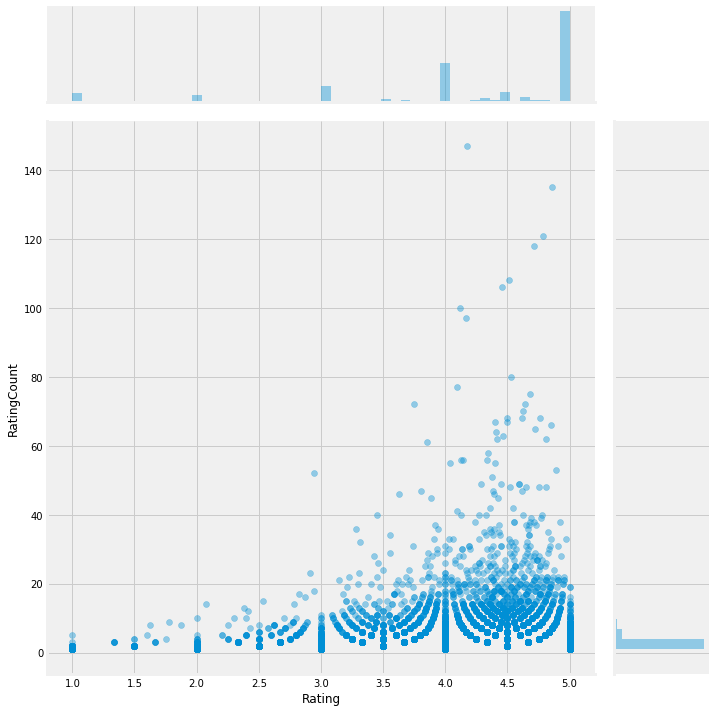

In [35]:
print('Plot of average ratings versus number of ratings'); print('--'*40)
g = sns.jointplot(x = 'Rating', y = 'RatingCount', data = byRatingUsers, alpha = 0.4, height = 10)

del g, byRatingUsers, popularity_recommender, user_id

<a id='o4'></a>
##### Observation 4 - Popularity Based Recommendation
* For popularity recommendation system, we recommended products based on *mean of Ratings* given by users. We saw that the top 5 products which we recommended to users are those where only 1 user from the training set has rated.
* Then we also explored other methods for popularity recommendations. Those were based on:
  * *Count of Ratings* received for the product
  * *Hybrid method* for popularity recommendation where in we used both mean and count of rating to decide on the product recommended
* For all of the above cases (recommendations based on mean, count, and mean and count), popularity based method lacks personalization i.e. same recommendations for all users. However, using Popularity based recommendation system it would easier to recommend products to a new user w/o having knowledge about who the users are or what their preferences are and recommending them the products that are in-trend.
* **RMSE of the popularity based recommendation method using mean of rating is 3.0894.**

<a id='collaborative'></a>
#### **Collaborative Filtering**
Objective is to build a recommendation system to recommend products to customers based on their previous ratings for other products i.e. item-based collaborative filtering.

**"You tend to like that item because you've liked those items."**

whereas as we know that in user-based it's "You may like it because your friends liked it".

  * Model-based Collaborative Filtering: Singular Value Decomposition and evaluate k-NN based algos.
  * Use the filtered ratings dataframe and scipy based SVD to evaluate Item-based collaborative filtering method for suggesting products based to users based on what he has liked in past.
  * Also explore user based collaborative filtering.

* Comment on the findings.


<a id='SVD'></a>
##### **Model based Collaborative Filtering: SVD**

In [36]:
# Item-based Collaborative Filtering
print('Matrix with one row per \'Product\' and one column per \'User\' for Item-based collaborative filtering'); print('--'*40)
ratings_item = ratings.pivot(index = 'UserID', columns = 'ProductID', values = 'Rating').fillna(0)
ratings_item.head()

Matrix with one row per 'Product' and one column per 'User' for Item-based collaborative filtering
--------------------------------------------------------------------------------


ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A100WO06OQR8BQ,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A105S56ODHGJEK,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A105TOJ6LTVMBG,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A10AFVU66A79Y1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [37]:
# Calculate the density of the rating matrix
print('Calculate the density of the ratings matrix'); print('--'*40)

print('Shape of ratings matrix: ', ratings_item.shape)

given_num_of_ratings = np.count_nonzero(ratings_item)
print('given_num_of_ratings = ', given_num_of_ratings)

possible_num_of_ratings = ratings_item.shape[0] * ratings_item.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Calculate the density of the ratings matrix
--------------------------------------------------------------------------------
Shape of ratings matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


In [38]:
# Singular Value Decomposition
U, sigma, Vt = svds(ratings_item, k = 10)
sigma = np.diag(sigma)

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = ratings_item.columns, index = ratings_item.index) #predicted ratings
preds_df.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.00,...,0.00,0.04,0.00,0.06,-0.00,0.01,0.00,0.13,0.06,0.02
A100WO06OQR8BQ,0.00,0.00,0.01,0.02,0.01,0.00,0.01,0.00,-0.00,0.00,...,0.00,0.03,0.00,0.00,-0.00,-0.00,0.00,-0.04,-0.01,0.00
A105S56ODHGJEK,-0.00,-0.00,0.00,0.02,0.01,-0.00,0.01,0.00,-0.01,-0.00,...,-0.00,0.01,-0.00,-0.02,0.02,-0.00,-0.00,-0.00,-0.01,-0.00
A105TOJ6LTVMBG,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00,...,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.02,-0.01,0.00
A10AFVU66A79Y1,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,-0.00,0.00,...,0.00,-0.00,-0.00,-0.03,0.00,-0.00,0.00,-0.05,-0.02,-0.00


In [39]:
# Recommend products with highest predicted ratings
print('Creating a function to recommend products with highest predicted ratings'); print('--'*40)
def recommend_items(user_id, ratings_item, preds_df, num_recommendations = 5):
    try:
        print('User has already rated products (from data in training set): {}'.format(train_data.loc[(train_data['UserID'] == user_id), 'ProductID'].nunique()))
        print('Top 5 products from what\'s already being rated: {}'.format(list(train_data[(train_data['UserID'] == user_id)].sort_values(by = 'Rating', ascending = False).head(5)['ProductID'])))
    except:
      print('There\'s no data for the selected user in training set')
    sorted_user_ratings = ratings_item.loc[user_id].sort_values(ascending = False)
    
    sorted_user_predictions = preds_df.loc[user_id].sort_values(ascending = False)
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis = 1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending = False)
    print('\nTop 5 recommendations for the user based on item-based collaborative filtering method')
    display(temp.head(num_recommendations))
    return temp.head(num_recommendations).index.tolist()

Creating a function to recommend products with highest predicted ratings
--------------------------------------------------------------------------------


In [40]:
print('Get top - K ( K = 5) recommendations.')
print('Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.'); print('--'*40)
result = {}

user_id = "A11D1KHM7DVOQK"
print(f'\nMake recommendation for the user id selected from the testset = "{user_id}"')
result[user_id] = recommend_items(user_id, ratings_item, preds_df)

user_id = "A149RNR5RH19YY"
print(f'\n\nMake recommendation for the user id selected from the testset = "{user_id}"')
result[user_id] = recommend_items(user_id, ratings_item, preds_df)

Get top - K ( K = 5) recommendations.
Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.
--------------------------------------------------------------------------------

Make recommendation for the user id selected from the testset = "A11D1KHM7DVOQK"
User has already rated products (from data in training set): 77
Top 5 products from what's already being rated: ['B0009H9PZU', 'B0006B486K', 'B00009W3DS', 'B0009E5YNA', 'B00005V54U']

Top 5 recommendations for the user based on item-based collaborative filtering method


,user_ratings,user_predictions
Recommended Items,,
B007WTAJTO,0.00,0.07
B005CT56F8,0.00,0.06
B00829THK0,0.00,0.06
B003ZSHNGS,0.00,0.06
B00825BZUY,0.00,0.06




Make recommendation for the user id selected from the testset = "A149RNR5RH19YY"
User has already rated products (from data in training set): 97
Top 5 products from what's already being rated: ['B00000JBAM', 'B000WR0CKE', 'B000BTL0OA', 'B0015AM30Y', 'B0000DIET2']

Top 5 recommendations for the user based on item-based collaborative filtering method


,user_ratings,user_predictions
Recommended Items,,
B00829THK0,0.00,0.33
B007WTAJTO,0.00,0.32
B00829TIEK,0.00,0.28
B002R5AM7C,0.00,0.27
B003ES5ZUU,0.00,0.27


In [0]:
compare_dict['SVD Item-based Collaborative Filtering'] = result

In [42]:
print('Evaluating SVD for Item-based Collaborative Filtering'); print('--'*60)
rmse_df = pd.concat([ratings_item.mean(), preds_df.mean()], axis = 1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
RMSE = round((((rmse_df['Avg_actual_ratings'] - rmse_df['Avg_predicted_ratings']) ** 2).mean() ** 0.5), 4)
print('RMSE OF ITEM BASED COLLABORATIVE FILTERING USING MATRIX FACTORIZATION METHOD (SVD): {}'.format(RMSE))

Evaluating SVD for Item-based Collaborative Filtering
------------------------------------------------------------------------------------------------------------------------
RMSE OF ITEM BASED COLLABORATIVE FILTERING USING MATRIX FACTORIZATION METHOD (SVD): 0.0033


<a id='o5'></a>
###### Observation 5 - Item Based Collaborative Filtering -- SVD
* Above we evaluated SVD for item-based collaborative filtering and it can be seen that the RMSE of SVD model 0.0033.

In [0]:
del (RMSE, U, sigma, Vt, all_user_predicted_ratings, given_num_of_ratings, possible_num_of_ratings, result, rmse_df, 
     density, preds_df, recommend_items, user_id)

<a id='product'></a>
##### **Product Similarity based on Sklearn Nearest Neighbor**

In [44]:
print('Product similarity based on Sklearn Nearest Neighbor'); print('--'*40)
k = 5
df_knn = ratings.pivot(index = 'ProductID', columns = 'UserID', values = 'Rating').fillna(0)
df_knn_matrix = csr_matrix(df_knn.values)

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors = k)
model_knn.fit(df_knn_matrix)

query_item = np.random.choice(df_knn.shape[0])
query_user = np.random.choice(df_knn.shape[1])
distances, indices = model_knn.kneighbors(df_knn.iloc[query_item, :].values.reshape(1, -1), n_neighbors = k+1)

for i in range(0, len(distances.flatten())):
  if i == 0:
    print('Recommendations for {0}:\n'.format(df_knn.index[query_item]))
  else:
    print('{0}: {1}, with distance of {2}:'.format(i, df_knn.index[indices.flatten()[i]], distances.flatten()[i]))

Product similarity based on Sklearn Nearest Neighbor
--------------------------------------------------------------------------------
Recommendations for B008R79VMQ:

1: B0017S37IG, with distance of 0.3845425451033364:
2: B003VVYL46, with distance of 0.3845425451033364:
3: B0016VA4L2, with distance of 0.3845425451033364:
4: B0014KO1M8, with distance of 0.3845425451033364:
5: B007UE2SPE, with distance of 0.3845425451033364:


<a id='knn'></a>
##### **Model based Collaborative Filtering: k-NN**

In [45]:
print('Further reducing the number of users'); 
print('Earlier we had considered users those who rated >=50 products, now to avoid memory issues let\'s take users those who\'ve rated >100 products')
print('--'*40)

ratings_df = ratings_df[ratings_df['UserIDCounts'] > 100]
print(f'Number of rows {ratings_df.shape[0]} and number of columns {ratings_df.shape[1]} in filtered dataframe')
print('Number of unique USERS in further filtered ratings dataframe = ', ratings_df['UserID'].nunique())
print('Number of unique PRODUCTS in further filteredratings dataframe = ', ratings_df['ProductID'].nunique())

ratings = ratings_df[['UserID', 'ProductID', 'Rating']]

Further reducing the number of users
Earlier we had considered users those who rated >=50 products, now to avoid memory issues let's take users those who've rated >100 products
--------------------------------------------------------------------------------
Number of rows 43309 and number of columns 6 in filtered dataframe
Number of unique USERS in further filtered ratings dataframe =  280
Number of unique PRODUCTS in further filteredratings dataframe =  22267


In [46]:
ratings['UserID'].value_counts().min()

101

In [47]:
train_data, test_data = train_test_split(ratings, test_size = 0.30, random_state = random_state)
display(train_data.shape, test_data.shape)

(30316, 3)

(12993, 3)

In [48]:
print('Getting the trainset and testset ready for recommender to be used'); print('--'*40)
reader = Reader(rating_scale = (0, 5))
data = Dataset.load_from_df(ratings[['UserID', 'ProductID', 'Rating']], reader)
trainset = Dataset.load_from_df(train_data[['UserID', 'ProductID', 'Rating']], reader); 
testset = Dataset.load_from_df(test_data[['UserID', 'ProductID', 'Rating']], reader); 

Getting the trainset and testset ready for recommender to be used
--------------------------------------------------------------------------------


In [49]:
%%time
print('ITEM BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGOS')
print('Grid Search across parameter grid to find best parameters using KNNBasic algorithm'); print('--'*40)
param_grid_KNNBasic = {'k': [3, 5, 10], 'sim_options': {'name': ['pearson_baseline', 'cosine'], 'user_based': [False]}, 'verbose': [False]}

gs_KNNBasic = GridSearchCV(KNNBasic, param_grid_KNNBasic, measures = ['rmse', 'mae'], cv = 3)
gs_KNNBasic.fit(trainset)
print(gs_KNNBasic.best_score['rmse'])
print(gs_KNNBasic.best_params['rmse'])

ITEM BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGOS
Grid Search across parameter grid to find best parameters using KNNBasic algorithm
--------------------------------------------------------------------------------
1.0315383659842756
{'k': 5, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'verbose': False}
CPU times: user 2min 12s, sys: 6.22 s, total: 2min 18s
Wall time: 2min 18s


In [50]:
%%time
print('ITEM BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGOS')
print('Grid Search across parameter grid to find best parameters using KNNWithMeans algorithm'); print('--'*40)
param_grid_KNNWithMeans = {'k': [3, 5, 10], 'sim_options': {'name': ['pearson_baseline', 'cosine'], 'user_based': [False]}, 'verbose': [False]}

gs_KNNWithMeans = GridSearchCV(KNNWithMeans, param_grid_KNNWithMeans, measures = ['rmse', 'mae'], cv = 3)
gs_KNNWithMeans.fit(trainset)
print(gs_KNNWithMeans.best_score['rmse'])
print(gs_KNNWithMeans.best_params['rmse'])

ITEM BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGOS
Grid Search across parameter grid to find best parameters using KNNWithMeans algorithm
--------------------------------------------------------------------------------
1.079754480905722
{'k': 10, 'sim_options': {'name': 'cosine', 'user_based': False}, 'verbose': False}
CPU times: user 2min 16s, sys: 1.2 s, total: 2min 18s
Wall time: 2min 17s


In [51]:
%%time
print('ITEM BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGOS')
print('Grid Search across parameter grid to find best parameters using KNNWithZScore algorithm'); print('--'*40)
param_grid_KNNWithZScore = {'k': [3, 5, 10], 'sim_options': {'name': ['pearson_baseline', 'cosine'], 'user_based': [False]}, 'verbose': [False]}

gs_KNNWithZScore = GridSearchCV(KNNWithZScore, param_grid_KNNWithZScore, measures = ['rmse', 'mae'], cv = 3)
gs_KNNWithZScore.fit(trainset)
print(gs_KNNWithZScore.best_score['rmse'])
print(gs_KNNWithZScore.best_params['rmse'])

ITEM BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGOS
Grid Search across parameter grid to find best parameters using KNNWithZScore algorithm
--------------------------------------------------------------------------------
1.0836895583873687
{'k': 10, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'verbose': False}
CPU times: user 2min 34s, sys: 1.2 s, total: 2min 35s
Wall time: 2min 35s


In [52]:
%%time
print('ITEM BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGOS')
print('Grid Search across parameter grid to find best parameters using KNNBaseline algorithm'); print('--'*40)
param_grid_KNNBaseline = {'bsl_options': {'method': ['als', 'sgd'], 'reg': [1, 2]}, 'k': [2, 3, 5], 
                          'sim_options': {'name': ['pearson_baseline', 'cosine'], 'user_based': [False]},
                          'verbose': [False]}

gs_KNNBaseline = GridSearchCV(KNNBaseline, param_grid_KNNBaseline, measures = ['rmse', 'mae'], cv = 3)
gs_KNNBaseline.fit(trainset)
print(gs_KNNBaseline.best_score['rmse'])
print(gs_KNNBaseline.best_params['rmse'])

ITEM BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGOS
Grid Search across parameter grid to find best parameters using KNNBaseline algorithm
--------------------------------------------------------------------------------
0.9655170623803802
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 5, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'verbose': False}
CPU times: user 8min 58s, sys: 4.71 s, total: 9min 3s
Wall time: 9min 1s


In [53]:
del param_grid_KNNBasic, param_grid_KNNWithMeans, param_grid_KNNWithZScore, gs_KNNBasic, gs_KNNWithMeans, gs_KNNWithZScore
gc.collect()

24

<a id='o6'></a>
###### Observation 6 - Algorithm choosen for Model based (Item) Collaborative Filtering using k-NN inspired method
* Above we evaluated different k-NN inspired algorithms for item-based collaborative filtering. It can be seen that KNNBaseline algorithm gives the lowest RMSE of ~0.966.
* k-fold cross-validate KNNBaseline algorithm using the best parameters, to see if there's any improvement in the RMSE.

In [54]:
%%time
print('ITEM BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGOS')
print('2-Fold cross validation using KNNBaseline and with best parameters identified during grid search'); print('--'*40)
kf = KFold(n_splits = 2)
algo = KNNBaseline(**gs_KNNBaseline.best_params['rmse'])
rmse_scores = []

for train_, test_ in kf.split(data):
    algo.fit(train_)
    predictions = algo.test(test_)
    rmse = round(accuracy.rmse(predictions, verbose = True), 4)
    rmse_scores.append(rmse)

    dump.dump('./dump_KNNBaseline_Item', predictions, algo)

print('--'*40)
print(f'RMSE OF ITEM BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGORITHM AND 2-FOLD CROSS VALIDATION {round(np.mean(rmse_scores), 4)}')

ITEM BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGOS
2-Fold cross validation using KNNBaseline and with best parameters identified during grid search
--------------------------------------------------------------------------------
RMSE: 0.9638
RMSE: 0.9672
--------------------------------------------------------------------------------
RMSE OF ITEM BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGORITHM AND 2-FOLD CROSS VALIDATION 0.9655
CPU times: user 18.6 s, sys: 4.82 s, total: 23.4 s
Wall time: 34.1 s


In [55]:
predictions, algo = dump.load('./dump_KNNBaseline_Item')
df_user = pd.DataFrame(predictions, columns = ['UserID', 'ProductID', 'ActualRating', 'EstRating', 'Details'])
df_user['Error'] = abs(df_user['EstRating'] - df_user['ActualRating'])
df_user.sort_values('Error', inplace = True, ascending = True)

display(df_user.head())

,UserID,ProductID,ActualRating,EstRating,Details,Error
11142,A2HRHF83I3NDGT,B005EOWBHC,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00
13565,A2IFGGXG3YV3Y6,B003ES5ZUU,5.00,5.00,"{'actual_k': 2, 'was_impossible': False}",0.00
13620,A1G650TTTHEAL5,B00ENZRS76,5.00,5.00,"{'actual_k': 5, 'was_impossible': False}",0.00
13777,A2B7BUH8834Y6M,B004CLYEFK,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00
359,A3V5F050GVZ56Q,B00F6E4HXG,5.00,5.00,"{'actual_k': 2, 'was_impossible': False}",0.00


Actual vs Prediction Comparison
--------------------------------------------------------------------------------


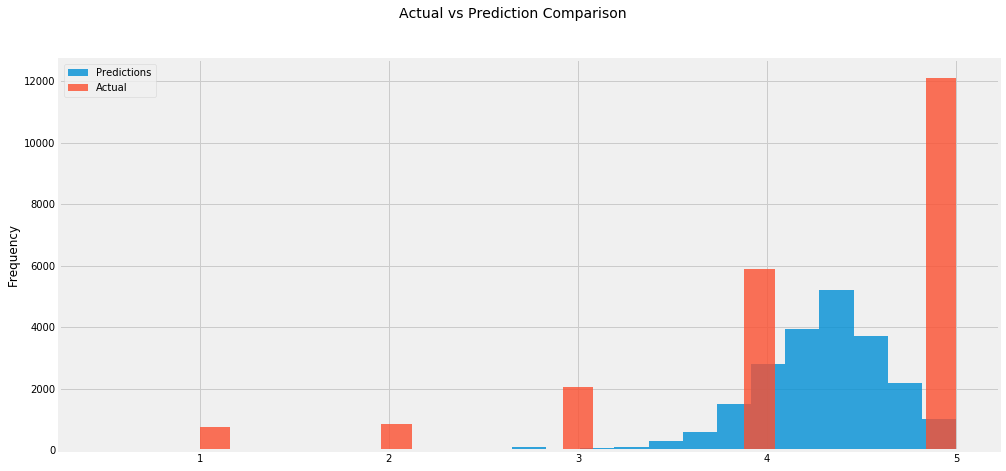

In [56]:
# Actual vs Prediction Comparison
print('Actual vs Prediction Comparison'); print('--'*40)

fig, ax = plt.subplots(figsize = (15, 7.2))
fig.suptitle('Actual vs Prediction Comparison', fontsize = 14)
df_user['EstRating'].plot.hist(bins = 25, alpha = 0.8)
df_user['ActualRating'].plot.hist(bins = 25, alpha = 0.8)
ax.legend(['Predictions', 'Actual'])
plt.show()

In [57]:
# Query top 5 recommendations for specific UserID
print('Get top - K ( K = 5) recommendations.')
print('Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.'); print('--'*40)
result = {}

def query_user(user_id):
  try:
    print('User "{}" has already rated products (from data in training set): {}'.format(user_id, train_data.loc[(train_data['UserID'] == user_id), 'ProductID'].nunique()))
    print('Top 5 products from what\'s already being rated: {}'.format(list(train_data[(train_data['UserID'] == user_id)].sort_values(by = 'Rating', ascending = False).head(5)['ProductID'])))
  except:
    print('There\'s no data for the selected user in training set')
  print('Top 5 recommendations for the user are: {}'.format(list(df_user[(df_user['UserID'] == user_id)].sort_values(by = 'EstRating', ascending = False).head(5)['ProductID'])))
  return list(df_user[(df_user['UserID'] == user_id)].sort_values(by = 'EstRating', ascending = False).head(5)['ProductID'])

# For e.g. querying for the following user
print('A check on what has the user liked in past (based on data available in training set, if there is) and making recommendations');
print('--'*40, '\n')

result['A11D1KHM7DVOQK'] = query_user('A11D1KHM7DVOQK')
print('\n')
result['A149RNR5RH19YY'] = query_user('A149RNR5RH19YY')

Get top - K ( K = 5) recommendations.
Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.
--------------------------------------------------------------------------------
A check on what has the user liked in past (based on data available in training set, if there is) and making recommendations
-------------------------------------------------------------------------------- 

User "A11D1KHM7DVOQK" has already rated products (from data in training set): 76
Top 5 products from what's already being rated: ['B00005V54U', 'B0001LD00A', 'B00061IYFQ', 'B0002I5RHG', 'B0009FUFPG']
Top 5 recommendations for the user are: ['B00008ZPNR', 'B00022TN9A', 'B0001FV35U', 'B0007Y79AI', 'B0000E1717']


User "A149RNR5RH19YY" has already rated products (from data in training set): 95
Top 5 products from what's already being rated: ['B000BTL0OA', 'B00003006E', 'B001OOZ1X2', 'B000062TTF', 'B00385XTWA']
Top 5 recommendations for the user are: ['B0

In [58]:
compare_dict['k-NN Item-based Collaborative Filtering'] = result
display(compare_dict)

{'PopularityRec': {'A11D1KHM7DVOQK': ['B0000645V0',
   'B0011YR8KO',
   'B00JE0Q95M',
   'B004T0B8O4',
   'B000VQU3N2'],
  'A149RNR5RH19YY': ['B0000645V0',
   'B0011YR8KO',
   'B00JE0Q95M',
   'B004T0B8O4',
   'B000VQU3N2']},
 'SVD Item-based Collaborative Filtering': {'A11D1KHM7DVOQK': ['B007WTAJTO',
   'B005CT56F8',
   'B00829THK0',
   'B003ZSHNGS',
   'B00825BZUY'],
  'A149RNR5RH19YY': ['B00829THK0',
   'B007WTAJTO',
   'B00829TIEK',
   'B002R5AM7C',
   'B003ES5ZUU']},
 'k-NN Item-based Collaborative Filtering': {'A11D1KHM7DVOQK': ['B00008ZPNR',
   'B00022TN9A',
   'B0001FV35U',
   'B0007Y79AI',
   'B0000E1717'],
  'A149RNR5RH19YY': ['B00003006E',
   'B001F51G16',
   'B000AMLXHW',
   'B00001P4ZH',
   'B000089GN3']}}

In [59]:
df_user.head()

,UserID,ProductID,ActualRating,EstRating,Details,Error
11142,A2HRHF83I3NDGT,B005EOWBHC,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00
13565,A2IFGGXG3YV3Y6,B003ES5ZUU,5.00,5.00,"{'actual_k': 2, 'was_impossible': False}",0.00
13620,A1G650TTTHEAL5,B00ENZRS76,5.00,5.00,"{'actual_k': 5, 'was_impossible': False}",0.00
13777,A2B7BUH8834Y6M,B004CLYEFK,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00
359,A3V5F050GVZ56Q,B00F6E4HXG,5.00,5.00,"{'actual_k': 2, 'was_impossible': False}",0.00


In [0]:
del (algo, ax, fig, gs_KNNBaseline, kf, param_grid_KNNBaseline, predictions, rmse, rmse_scores, train_, test_)

<a id='o7'></a>
###### Observation 7 - Item based Collaborative Filtering (k-NN)
* Using k-NN inspired algos for item based collaborative filtering  and 2-Fold cross validation, we get a RMSE score of ~0.9655.

In [61]:
%%time
print('USER BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGOS')
print('Grid Search across parameter grid to find best parameters using KNNBaseline algorithm'); print('--'*40)
param_grid_KNNBaseline = {'bsl_options': {'method': ['als', 'sgd'], 'reg': [1, 2]}, 'k': [2, 3, 5], 
                          'sim_options': {'name': ['pearson_baseline', 'cosine'], 'user_based': [True]},
                          'verbose': [False]}

gs_KNNBaseline = GridSearchCV(KNNBaseline, param_grid_KNNBaseline, measures = ['rmse', 'mae'], cv = 3)
gs_KNNBaseline.fit(trainset)
print(gs_KNNBaseline.best_score['rmse'])
print(gs_KNNBaseline.best_params['rmse'])

USER BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGOS
Grid Search across parameter grid to find best parameters using KNNBaseline algorithm
--------------------------------------------------------------------------------
0.981338916827777
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 5, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'verbose': False}
CPU times: user 18.8 s, sys: 9.47 ms, total: 18.8 s
Wall time: 18.8 s


In [62]:
%%time
print('USER BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGOS')
print('2-Fold cross validation using KNNBaseline and with best parameters identified during grid search'); print('--'*40)
kf = KFold(n_splits = 2)
algo = KNNBaseline(**gs_KNNBaseline.best_params['rmse'])
rmse_scores = []

for train_, test_ in kf.split(data):
    algo.fit(train_)
    predictions = algo.test(test_)
    rmse = round(accuracy.rmse(predictions, verbose = True), 4)
    rmse_scores.append(rmse)

    dump.dump('./dump_KNNBaseline_User', predictions, algo)

print('--'*40)
print(f'RMSE OF USER BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGORITHM AND 2-FOLD CROSS VALIDATION {round(np.mean(rmse_scores), 4)}')

USER BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGOS
2-Fold cross validation using KNNBaseline and with best parameters identified during grid search
--------------------------------------------------------------------------------
RMSE: 0.9860
RMSE: 0.9793
--------------------------------------------------------------------------------
RMSE OF USER BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGORITHM AND 2-FOLD CROSS VALIDATION 0.9826
CPU times: user 1.4 s, sys: 16 ms, total: 1.41 s
Wall time: 1.42 s


In [63]:
predictions, algo = dump.load('./dump_KNNBaseline_User')
df_user = pd.DataFrame(predictions, columns = ['UserID', 'ProductID', 'ActualRating', 'EstRating', 'Details'])
df_user['Error'] = abs(df_user['EstRating'] - df_user['ActualRating'])
df_user.sort_values('Error', inplace = True, ascending = True)

display(df_user.head())

,UserID,ProductID,ActualRating,EstRating,Details,Error
4751,A3OXHLG6DIBRW8,B000TKHBDK,5.00,5.00,"{'actual_k': 2, 'was_impossible': False}",0.00
8928,A18U49406IPPIJ,B009QUDLC4,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00
4367,A31N0XY2UTB25C,B00BOHNYTW,5.00,5.00,"{'actual_k': 3, 'was_impossible': False}",0.00
6663,A2KOV8XWZOZ0FQ,B001TH7T2U,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00
20132,AEJAGHLC675A7,B001TH7GUU,5.00,5.00,"{'actual_k': 3, 'was_impossible': False}",0.00


In [64]:
print('A check on what has the user liked in past (based on data available in training set, if there is) and making recommendations');
print('--'*40, '\n')
result = {}

result['A11D1KHM7DVOQK'] = query_user('A11D1KHM7DVOQK')
print('\n')
result['A149RNR5RH19YY'] = query_user('A149RNR5RH19YY')

A check on what has the user liked in past (based on data available in training set, if there is) and making recommendations
-------------------------------------------------------------------------------- 

User "A11D1KHM7DVOQK" has already rated products (from data in training set): 76
Top 5 products from what's already being rated: ['B00005V54U', 'B0001LD00A', 'B00061IYFQ', 'B0002I5RHG', 'B0009FUFPG']
Top 5 recommendations for the user are: ['B00004T8R2', 'B0009H9PZU', 'B00009L1RI', 'B00008VF63', 'B000069106']


User "A149RNR5RH19YY" has already rated products (from data in training set): 95
Top 5 products from what's already being rated: ['B000BTL0OA', 'B00003006E', 'B001OOZ1X2', 'B000062TTF', 'B00385XTWA']
Top 5 recommendations for the user are: ['B000VE7S9Q', 'B000089GN3', 'B00008I9K8', 'B00006HYKM', 'B000MK4GGM']


In [65]:
compare_dict['k-NN User-based Collaborative Filtering'] = result
display(compare_dict)

{'PopularityRec': {'A11D1KHM7DVOQK': ['B0000645V0',
   'B0011YR8KO',
   'B00JE0Q95M',
   'B004T0B8O4',
   'B000VQU3N2'],
  'A149RNR5RH19YY': ['B0000645V0',
   'B0011YR8KO',
   'B00JE0Q95M',
   'B004T0B8O4',
   'B000VQU3N2']},
 'SVD Item-based Collaborative Filtering': {'A11D1KHM7DVOQK': ['B007WTAJTO',
   'B005CT56F8',
   'B00829THK0',
   'B003ZSHNGS',
   'B00825BZUY'],
  'A149RNR5RH19YY': ['B00829THK0',
   'B007WTAJTO',
   'B00829TIEK',
   'B002R5AM7C',
   'B003ES5ZUU']},
 'k-NN Item-based Collaborative Filtering': {'A11D1KHM7DVOQK': ['B00008ZPNR',
   'B00022TN9A',
   'B0001FV35U',
   'B0007Y79AI',
   'B0000E1717'],
  'A149RNR5RH19YY': ['B00003006E',
   'B001F51G16',
   'B000AMLXHW',
   'B00001P4ZH',
   'B000089GN3']},
 'k-NN User-based Collaborative Filtering': {'A11D1KHM7DVOQK': ['B00004T8R2',
   'B0009H9PZU',
   'B00009L1RI',
   'B00008VF63',
   'B000069106'],
  'A149RNR5RH19YY': ['B000VE7S9Q',
   'B000089GN3',
   'B00008I9K8',
   'B00006HYKM',
   'B000MK4GGM']}}

<a id='o8'></a>
###### Observation 8 - User based Collaborative Filtering (k-NN)
* Using k-NN inspired algos for user based collaborative filtering  and 2-Fold cross validation, we get a RMSE score of ~0.9826. 

<a id='conclusion'></a>
### Conclusion
* Non-personalized based recommendation system (such as popularity) is generated by averaging the recommendations for all the users. Here we recommended top 5 products to the users. Also saw how we can make use of count to suggest popular products to the users and hybrid popularity based recommender based on a combination of mean and count. However in popularity based recommendation, all users receive same recommendations. RMSE of popularity recommendation method based on mean of ratings was 3.0894.

* Collaborative-based recommendations are personalized since the rating "prediction" differs depending on the target user and it is based on
  * User-to-user: ratings for a given product expressed by users that are similar to the active user.
  * Item-to-item: weighted average of the ratings of the active users for the similar items.

* Collaborative based filtering method requires a minimal knowledge engineering efforts when compared to methods such as content-based recsys. This method is based on user history, but what if the user is new (where there is no user history)? It's one of the limitations of the method known as cold-start problem.

* Items with lots of history gets recommended a lot, while those without never make it into the recommendation engine.

* Additionally, collaborative based filtering methods face scalability issues particularly in our case where the number of users (4,201,696) and items (476,002) were high (sparse data), especially when recommendations need to be generated in real-time online. To overcome this, we filtered users who have rated at least 50 products, this left about 1,540 number of users and 48,190 products in the dataframe and these were further reduced to select only those users with > 100 ratings to avoid memory issues while using k-NN inspired algorithms.

* Since our goal was to build a recsys to recommend products to customers based on their previous ratings for other products, we built an item-based collaborative filtering recommendation system. Used two model-based approaches to do that: SVD and k-NN inspired algos.

* We saw that SVD had a RMSE score of 0.0033. We also compared various k-NN based algorithms using grid search method and found that KNN Baseline algo gave the lowest RMSE, we then used 2-fold cross validation technique which gave a RMSE of 0.9655.

* Also explored kNN Baseline algo for user-based collaborative filtering, RMSE (0.9826) was slightly higher than item-based CF.